## Sports Betting Model

In [1]:
# import statements

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score
import statistics
import scipy.stats
from scipy.stats import norm

import selenium 
from bs4 import BeautifulSoup

import random
import matplotlib.pyplot as plt

### Functions

In [2]:
# given regression model, returns cross_val_score, r^2 score, mean squared error, and mean absolute error

def evaluate_regression_model(model, X_true, y_true):
    
    model.fit(X_true, y_true)
    y_pred = model.predict(X_true)
    
    # optimal return is 1, 1, 0, 0
    cross_val = statistics.mean(cross_val_score(model, X_true, y_true, cv=5))
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mae = metrics.mean_absolute_error(y_true, y_pred)
    return cross_val, r2, mse, mae

In [3]:
# given classification model, returns cross_val_score, accuracy, precision, recall

def evaluate_classification_model(model, X_true, y_true):
    
    model.fit(X_true, y_true)
    y_pred = model.predict(X_true)
    
    # optimal return is 1, 1, 1, 1
    cross_val = statistics.mean(cross_val_score(model, X_true, y_true, cv=5))
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred) 
    recall = metrics.recall_score(y_true, y_pred)
    return cross_val, accuracy, precision, recall

In [4]:
# returns True if bet would have hit and False otherwise

def hit(line, prediction, actual):
    
    if actual < line and prediction < line:
        return True
    elif actual > line and prediction > line:
        return True
    else:
        return False

In [5]:
# returns only selected features of X

def select_features(X):
    
    feature_selection_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',Lasso())
    ])
    
    search = GridSearchCV(feature_selection_pipeline,
                          {'model__alpha':np.arange(0.1,10,0.1)},
                          cv = 5, scoring="neg_mean_squared_error",verbose=0
                         )
    search.fit(X, y)

    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)
    selected_features = np.array(features)[importance > 0]
    print("Selected:", selected_features)

    unselected_features = np.array(features)[importance == 0]
    print("Unselected:", unselected_features)

    return X[selected_features]

In [6]:
# return probability of OVER given line, estimate, mean_error, and stdev_error

def regression_probability(line, estimate, mean_error, stdev_error):
    
    z_score = ((line-estimate)-mean_error) / stdev_error
    return 1-scipy.stats.norm.cdf(z_score) 

### Load Data

In [7]:
# Load Data

from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [8]:
features = fetch_california_housing()['feature_names']
features

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [9]:
# Scale Data

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=features)

In [10]:
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818


In [11]:
y.head(5)

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

### Feature Selection

In [12]:
# X = select_features(X)

### Test Various Models

https://scikit-learn.org/stable/supervised_learning.html

In [13]:
# Test Regression Models

model_input = X
model_output = y

MLPRegressor_model = MLPRegressor(max_iter=500)
KernelRidge_model = KernelRidge()
SVR_model = SVR()
SGDRegressor_model = SGDRegressor()
KNeighborsRegressor_model = KNeighborsRegressor()
GaussianProcessRegressor_model = GaussianProcessRegressor()
PLSRegression_model = PLSRegression()
DecisionTreeRegressor_model = DecisionTreeRegressor()

regression_models = [MLPRegressor_model, KernelRidge_model, SVR_model, 
                    SGDRegressor_model, KNeighborsRegressor_model, GaussianProcessRegressor_model, 
                    PLSRegression_model, DecisionTreeRegressor_model]

print("Model (Cross Validation, R2, MSE, MAE)")
for model in regression_models:
    print(str(model)[:str(model).index("(")], evaluate_regression_model(model, model_input, model_output))

Model (R2, MSE, MAE)
MLPRegressor (0.709865740960103, 0.7904980583169863, 0.27896237331573837, 0.3618364570275143)
KernelRidge (-4.067673242737092, -2.607264361717011, 4.803253943318696, 2.0707386197116935)
SVR (0.6679205432667834, 0.7502397399037284, 0.33256834927970075, 0.38163177724948144)
SGDRegressor (-1084537.3582584884, -37366.233005750706, 49756.35032203417, 30.72699562548284)
KNeighborsRegressor (0.523725587205614, 0.7985691404441083, 0.26821532148738403, 0.3503088939922481)
GaussianProcessRegressor (-14575.24915377559, 0.9995291084260609, 0.0006270158165846033, 0.006442707849047219)
PLSRegression (0.4544166266489375, 0.5266352328073278, 0.6303089978035576, 0.5891030625492538)
DecisionTreeRegressor (0.34743780154906967, 1.0, 1.0338511378986614e-31, 4.333312348052452e-17)


In [14]:
# Test Bayesian Ridge Regression Model

model_input = X
model_output = y

BayesianRidge_model = BayesianRidge(n_iter=500)

BayesianRidge_model.fit(model_input, model_output)
y_pred = BayesianRidge_model.predict(model_input, return_std=True)

cross_val = statistics.mean(cross_val_score(BayesianRidge_model, model_input, model_output, cv=5))
r2 = metrics.r2_score(model_output, y_pred[0])
mse = metrics.mean_squared_error(model_output, y_pred[0]) 
mae = metrics.mean_absolute_error(model_output, y_pred[0])

print(cross_val, r2, mse, mae) # regression results
print(statistics.mean(y_pred[1])) # standard deviation for each prediction

0.553037297534787 0.606232555185614 0.5243211593050423 0.5311589374967698
0.7243786052474678


In [15]:
# Test Classification Models

model_input = X
model_output = [random.randint(0,1) for _ in range(len(y))]

MLPClassifier_model = MLPClassifier()
SVC_model = SVC()
SGDClassifier_model = SGDClassifier()
KNeighborsClassifier_model = KNeighborsClassifier()
NearestCentroid_model = NearestCentroid()
GaussianProcessClassifier_model = GaussianProcessClassifier()
DecisionTreeClassifier_model = DecisionTreeClassifier()

classification_models = [MLPClassifier_model, SVC_model, SGDClassifier_model, KNeighborsClassifier_model, 
                        NearestCentroid_model, GaussianProcessClassifier_model, DecisionTreeClassifier_model]

print("Model (Cross Validation, Accuracy, Precision, Recall)")
for model in classification_models:
    print(str(model)[:str(model).index("(")], evaluate_classification_model(model, model_input, model_output))

Model (Accuracy, Precision, Recall)
MLPClassifier (0.4994186046511628, 0.5432170542635659, 0.5350961184355896, 0.6998362392833061)
SVC (0.4987403100775194, 0.525484496124031, 0.5183770584183833, 0.7975146902995858)
SGDClassifier (0.5034883720930232, 0.4935562015503876, 0.49438727782974745, 0.3054619015509103)
KNeighborsClassifier (0.5010174418604652, 0.6881298449612403, 0.688096146508966, 0.6949234177824872)
NearestCentroid (0.5032461240310078, 0.5079457364341086, 0.5093508436538942, 0.5903092187650515)
GaussianProcessClassifier (0.4950096899224806, 0.5762596899224807, 0.5730236712818222, 0.617955880936326)
DecisionTreeClassifier (0.4936531007751938, 1.0, 1.0, 1.0)


### Make Predictions

In [16]:
# Regression-Based (Estimate, Mean Error, Standard Deviation Error)

model_input = X
model_output = y
model = MLPRegressor_model

model_predictions = model.predict(model_input)
errors = model_predictions - model_output
mean_error = statistics.mean(errors)
stdev_error = statistics.stdev(errors)

print(str(round(regression_probability(25, 24, 0, 1)*100, 2)) + "%") # probability of over

15.87%


(array([0.01575169, 0.01794959, 0.02381069, 0.03882974, 0.04102764,
        0.0542151 , 0.06007619, 0.07399629, 0.11282602, 0.14762626,
        0.22748364, 0.3150337 , 0.4575315 , 0.73886392, 1.0132363 ,
        1.22167139, 1.03375012, 0.73300283, 0.46705578, 0.27254078,
        0.17400117, 0.09670802, 0.06154147, 0.03919605, 0.02271173,
        0.01538537, 0.01172218, 0.00659373, 0.0040295 , 0.00183159]),
 array([-2.        , -1.86666667, -1.73333333, -1.6       , -1.46666667,
        -1.33333333, -1.2       , -1.06666667, -0.93333333, -0.8       ,
        -0.66666667, -0.53333333, -0.4       , -0.26666667, -0.13333333,
         0.        ,  0.13333333,  0.26666667,  0.4       ,  0.53333333,
         0.66666667,  0.8       ,  0.93333333,  1.06666667,  1.2       ,
         1.33333333,  1.46666667,  1.6       ,  1.73333333,  1.86666667,
         2.        ]),
 <BarContainer object of 30 artists>)

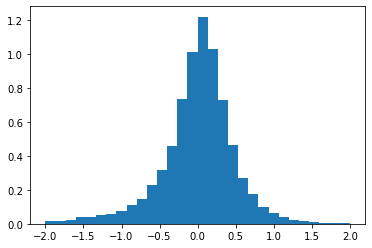

In [17]:
# Plot histogram of errors to assess normality

plt.hist(errors, density=True, bins=30, range=(-2, 2))

In [18]:
# Bayesian-Regression Based (Estimate, Probability)

In [19]:
# Classification-Based (Class, Probability)

model_input = X
model_output = [1] * len(y)

model = MLPClassifier_model
model_predictions = model.predict(model_input)
model_probabilities = [round(vals[0]*100, 2) for vals in model.predict_proba(model_input)] # could be vals[1]

### Strategies

1. Profitability (calculate bet EV based on betting odds + probability estimation)
2. Probability (anything above a probability threshold)